In [ ]:
import os  # file paths
import glob # gathering csv's
import copy # deep copies
import pandas as pd  # dataframes
import numpy as np # numerical transformations and evenly spaced ticks
import scipy.stats as stats # statistical significance
import matplotlib.pyplot as plt  # plotting
import seaborn as sns  # plotting

# set working directory for relative file paths
while not os.getcwd().endswith("frm2"):
    print(f'current wd: {os.getcwd()} \n\t not "frm2/", changing ...')
    os.chdir("..")

print(f"wd: {os.getcwd()}")

current wd: c:\Users\jak-w\OneDrive - University of Connecticut\1-Projects\frm2\code 
	 not "frm2/", changing ...
wd: c:\Users\jak-w\OneDrive - University of Connecticut\1-Projects\frm2


In [3]:
def get_img(filename):
    filename = str.split(filename, "\\")
    csv = filename[-1]
    img = str.split(csv, ".")[-2]
    img = img[:-2]
    return img

def get_compartment(img: str):
    compartment = img[-1:]
    return compartment

def get_experiment(img: str):
    experiment = img[:10]
    experiment_number = lambda experiment: (
        1 if experiment == "2024-05-05" else
        2 if experiment == "2024-07-04" else
        3 if experiment == "2024-08-04" else None)
    return experiment_number(experiment)

def get_treatment(img: str):
    treatment = lambda img: (
        "Control" if "ctrl" in img else
        "FRM2-KD" if "kd" in img else None)
    return treatment(img)


In [ ]:
# collect csv paths
csv_path = 'results/.csv/frm2-aid_mapple-rab6_compartments/*.csv'
all_csv = glob.glob(csv_path)
# initialize empty lists for collection
csv_list = []
grouping_cols = []
numeric_cols = []
# loop csv's and collect data
for filename in all_csv:
    img = get_img(filename)
    compartment = get_compartment(img)
    experiment = get_experiment(img)
    treatment = get_treatment(img)
    unique_id = str(experiment) +"_"+ treatment +"_"+ img[-2:] +"_"+ str(compartment)
    df0 = pd.read_csv(filename)
    df0.columns = df0.columns.str.lower()
    grouping_cols = ['unique_id', 'experiment', 'treatment', 'img', 'compartment']
    numeric_cols = list(df0.columns[1:].difference(['slice']))
    df0[grouping_cols] = [unique_id, experiment, treatment, img, compartment]
    df0 = df0[grouping_cols + ['slice'] + numeric_cols]
    csv_list.append(df0)
df0 = pd.concat(csv_list, ignore_index=True)
# filter artifacts
for col in numeric_cols:
    lower_bound = df0.groupby("treatment")[col].transform(lambda x: x.quantile(0.01))
    upper_bound = df0.groupby("treatment")[col].transform(lambda x: x.quantile(0.99))
    df0 = df0[(df0[col] > lower_bound) & (df0[col] < upper_bound)]
df0.dropna()
# calculate descriptive statistics
df0_stats = df0.groupby("treatment")[numeric_cols].describe()
df0.head(10)


,unique_id,experiment,treatment,img,compartment,slice,ar,area,circ.,round,solidity
0,1_Control_01_1,1,Control,2024-05-05_frm2-aid_mapple-rab6_ctrl_01,1,1,1.855,0.743,0.806,0.539,0.883
1,1_Control_01_1,1,Control,2024-05-05_frm2-aid_mapple-rab6_ctrl_01,1,2,1.839,0.819,0.745,0.544,0.871
2,1_Control_01_1,1,Control,2024-05-05_frm2-aid_mapple-rab6_ctrl_01,1,3,2.008,0.701,0.706,0.498,0.850
3,1_Control_01_1,1,Control,2024-05-05_frm2-aid_mapple-rab6_ctrl_01,1,3,1.241,0.042,0.982,0.806,0.800
4,1_Control_01_1,1,Control,2024-05-05_frm2-aid_mapple-rab6_ctrl_01,1,4,2.022,0.693,0.683,0.495,0.842
5,1_Control_01_1,1,Control,2024-05-05_frm2-aid_mapple-rab6_ctrl_01,1,5,2.286,0.668,0.563,0.437,0.764
6,1_Control_01_1,1,Control,2024-05-05_frm2-aid_mapple-rab6_ctrl_01,1,6,2.040,0.823,0.672,0.490,0.829
7,1_Control_01_1,1,Control,2024-05-05_frm2-aid_mapple-rab6_ctrl_01,1,7,2.146,0.752,0.614,0.466,0.796
8,1_Control_01_1,1,Control,2024-05-05_frm2-aid_mapple-rab6_ctrl_01,1,8,1.273,0.470,0.932,0.786,0.911
9,1_Control_01_1,1,Control,2024-05-05_frm2-aid_mapple-rab6_ctrl_01,1,8,1.326,0.227,0.933,0.754,0.908


0.3919913496376812


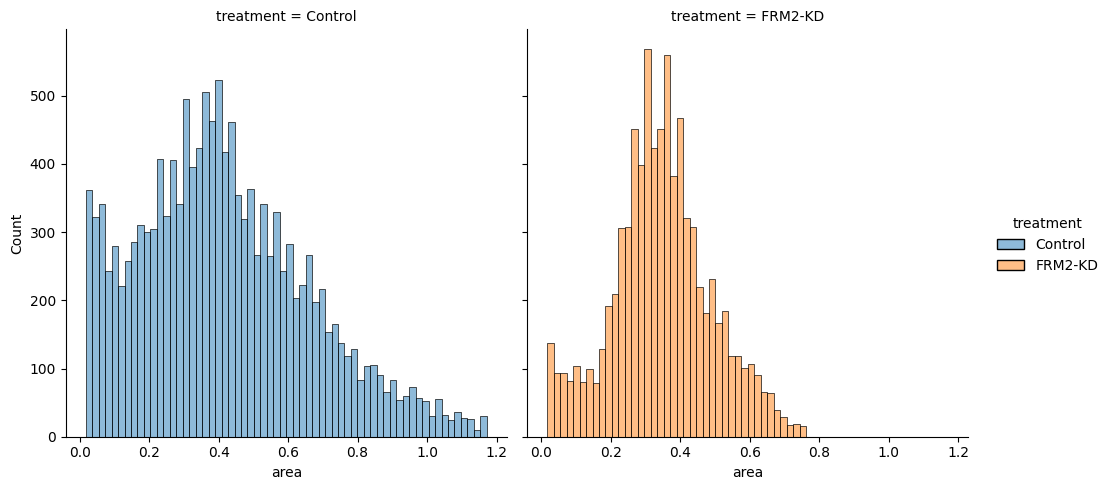

In [18]:
sns.displot(
    data=df0,
    x='area',
    kind='hist',
    col='treatment',
    hue='treatment',
)
print(np.mean(df0['area']))

In [5]:
# create deep copy for area analysis
adf = copy.deepcopy(df0[['unique_id', 'experiment', 'treatment', 'compartment', 'area']])
# Create deep copy for change in area over time (delta)
ddf = copy.deepcopy(df0[['unique_id', 'experiment', 'treatment', 'compartment', 'area']])
ddf['delta'] = ddf.groupby(['unique_id'])['area'].diff()
ddf['delta'] = ddf['delta'].abs()
ddf.drop(columns='area', inplace=True)
ddf.dropna(inplace=True)
# lower_bound = ddf.groupby("treatment")['delta'].transform(lambda x: x.quantile(0.05))
# upper_bound = ddf.groupby("treatment")['delta'].transform(lambda x: x.quantile(0.95))
# ddf = ddf[(ddf['delta'] > lower_bound) & (ddf['delta'] < upper_bound)]


In [6]:

# Average area by compartment
area_comp_adf = copy.deepcopy(adf)
area_comp_adf['area'] = area_comp_adf.groupby(['unique_id', 'experiment', 'treatment', 'compartment']).transform('mean')
area_comp_adf.drop_duplicates(inplace=True, ignore_index=True)
area_comp_adf

# Average area by experiment
area_exp_adf = copy.deepcopy(adf)
area_exp_adf['area'] = area_exp_adf.groupby(['experiment', 'treatment'])['area'].transform('mean')
area_exp_adf.drop_duplicates(subset=['area'], inplace=True, ignore_index=True)
area_exp_adf

# Separate the data by treatment
control_data = area_exp_adf[area_exp_adf["treatment"] == "Control"]["area"]
treatment_data = area_exp_adf[area_exp_adf["treatment"] == "FRM2-KD"]["area"]

ctrl_n = len(adf[adf['treatment'] == 'Control']['unique_id'].unique())
kd_n = len(adf[adf['treatment'] == 'FRM2-KD']['unique_id'].unique())
# Perform the t-test
area_t, area_p = stats.ttest_rel(control_data, treatment_data)
area_t, area_p = round(area_t, 3), round(area_p, 3)

print(f'Area comparison\n\tT-stat: {area_t}, p-value: {area_p}\n\tControl n: {ctrl_n}\n\tFRM2-KD n: {kd_n}\n\tInd. Exps: 03')

Area comparison
	T-stat: 9.464, p-value: 0.011
	Control n: 31
	FRM2-KD n: 32
	Ind. Exps: 03


In [7]:
# Average delta by compartment
delta_comp_df = copy.deepcopy(ddf)
delta_comp_df['delta'] = delta_comp_df.groupby(['unique_id', 'experiment', 'treatment', 'compartment'])['delta'].transform('mean')
delta_comp_df.drop_duplicates(inplace=True, ignore_index=True)
delta_comp_df

,unique_id,experiment,treatment,compartment,delta
0,1_Control_01_1,1,Control,1,0.219480
1,1_Control_02_2,1,Control,2,0.056242
2,1_Control_03_3,1,Control,3,0.299077
3,1_Control_04_4,1,Control,4,0.135203
4,1_Control_05_5,1,Control,5,0.049676
...,...,...,...,...,...
58,3_FRM2-KD_07_7,3,FRM2-KD,7,0.091794
59,3_FRM2-KD_08_8,3,FRM2-KD,8,0.119095
60,3_FRM2-KD_09_9,3,FRM2-KD,9,0.057942
61,3_FRM2-KD_10_0,3,FRM2-KD,0,0.148538


In [8]:

# Average delta by experiment
delta_exp_df = copy.deepcopy(ddf)
delta_exp_df['delta'] = delta_exp_df.groupby(['experiment', 'treatment'])['delta'].transform('mean')
delta_exp_df.drop_duplicates(subset=['delta'], inplace=True, ignore_index=True)
# Separate the data by treatment
control_data = delta_exp_df[delta_exp_df["treatment"] == "Control"]["delta"]
treatment_data = delta_exp_df[delta_exp_df["treatment"] == "FRM2-KD"]["delta"]
ctrl_n = len(ddf[ddf['treatment'] == 'Control']['unique_id'].unique())
kd_n = len(ddf[ddf['treatment'] == 'FRM2-KD']['unique_id'].unique())
# Perform the t-test
delta_t, delta_p = stats.ttest_rel(control_data, treatment_data)
delta_t, delta_p = round(delta_t, 3), round(delta_p, 3)

print(f'Delta area comparison\n\tT-stat: {delta_t}, p-value: {delta_p}\n\tControl n: {ctrl_n}\n\tFRM2-KD n: {kd_n}\n\tInd. Exps: 03')


Delta area comparison
	T-stat: 11.106, p-value: 0.008
	Control n: 31
	FRM2-KD n: 32
	Ind. Exps: 03


In [9]:
def format_col_title(col):
    col_parts = col.split("_")
    if len(col_parts) > 1:
        for i in range(len(col_parts)):
            if col_parts[i] == "track":
                col_parts[i] = ""  # Use assignment operator to remove "track"
            else:
                col_parts[i] = col_parts[i].capitalize()
        col = " ".join(
            col_parts
        ).strip()  # Use strip() to remove any leading/trailing spaces
    else:
        col = col.capitalize()
    return col

def customize_ticks(maximum, n_ticks=3):
    min_y, max_y = 0, np.round(maximum, 1)
    custom_ticks = np.linspace(min_y, max_y, n_ticks)
    return custom_ticks

box_pal = ['#999999', '#FFBD57']
box_pal = sns.color_palette(box_pal)
exp_pal = sns.cubehelix_palette(n_colors=3, start=3, rot=6, gamma=1, hue=2, light=0.8, dark=0.5)


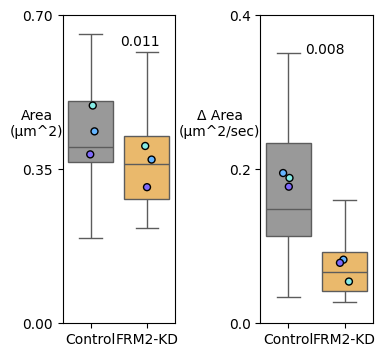

0.011 9.464 31 32


In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4,4))

ax = axes[0]
sns.boxplot(
    data=area_comp_adf,
    x='treatment',
    y='area',
    hue="treatment",
    palette=box_pal,
    width=0.8,
    ax=ax,
)
sns.stripplot(
    data=area_exp_adf,
    x='treatment',
    y='area',
    hue='experiment',
    palette=exp_pal,
    ax=ax,
    jitter=True,
    dodge=False,
    edgecolor='black',
    linewidth=1,
    legend=False
)
ax.set_xlabel("")
ax.set_ylabel("Area\n(μm^2)", rotation=0)
ax.yaxis.set_label_coords(-0.23, 0.6)
maximum = ax.get_yticks()[-1]
ax.set_yticks(customize_ticks(maximum))
ax.set_ylim(0, maximum)

ax = axes[1]
sns.boxplot(
    data=delta_comp_df,
    x='treatment',
    y='delta',
    hue="treatment",
    palette=box_pal,
    width=0.8,
    ax=ax,
)
sns.stripplot(
    data=delta_exp_df,
    x='treatment',
    y='delta',
    hue='experiment',
    palette=exp_pal,
    ax=ax,
    jitter=True,
    dodge=False,
    edgecolor='black',
    linewidth=1,
    legend=False,
)
ax.set_xlabel(format_col_title(''), rotation=0)
ax.set_ylabel("Δ Area\n(μm^2/sec)", rotation=0, loc='center')
ax.yaxis.set_label_coords(-0.36, 0.6)
maximum = ax.get_yticks()[-1]
ax.set_yticks(customize_ticks(maximum))
ax.set_ylim(0, maximum)

plt.text(x=-3, y=0.36, s=area_p)
plt.text(x=0.3, y=0.35, s=delta_p)

plt.subplots_adjust(wspace=.76)
plt.savefig('results/.png/frm2-aid-rab6-stack-areas.png', format='png', dpi=300, bbox_inches='tight')
plt.savefig('results/.svg/frm2-aid-rab6-stack-areas.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()
print(area_p, area_t, ctrl_n, kd_n)
